# Modules

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from community import community_louvain
import matplotlib.cm as cm
import csv
import random

%matplotlib inline

# Functions

In [73]:
def create_kegg_graph(data_df, include_reactions = True):
    
    G = nx.MultiDiGraph()  # At first create multigraph, later it can be converted
    
    unique_entries = []  # List of unique entries. Each gene, ompound, etc needs to be stored as 1 node
    
    # Iterate data to create all nodes
    for index, entry in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and entry['link type']=='reaction':
            continue            
        
        # -- Handle node for Head --
        n1 = entry['head id']
        if n1 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n1)
            
            #Add node n1
            G.add_node(n1)
            # Assign node type
            if n1[0:3] == 'hsa':
                t = 'gene'
            elif n1[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n1.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['head full name'] == '':
                full_name = n1
            else:
                full_name = entry['head full name']
            pathway = str(entry['pathway'])
            attr = {n1: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n1]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n1]['pathways'] = temp

        # -- Handle node for Tail --
        n2 = entry['tail id']
        if n2 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n2)
            
            #Add node n2
            G.add_node(n2)
            # Assign node type
            if n2[0:3] == 'hsa':
                t = 'gene'
            elif n2[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n2.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['tail full name'] == '':
                full_name = n2
            else:
                full_name = entry['tail full name']
            pathway = str(entry['pathway'])
            attr = {n2: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n2]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n2]['pathways'] = temp
        
        
     # Iterate data to find all relations           
    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and row['link type']=='reaction':
            continue 
        
        head = str(row['head id'])
        tail = str(row['tail id'])
        pathway = str(row['pathway'])
        link_type = str(row['link type'])
        rel_name = str(row['relation name'])
        if head in G.nodes and tail in G.nodes:
            G.add_edge(head, tail,pathway = pathway, link_type= link_type, relation_name= rel_name)
        else:
            print('node not found @row '+str(index))
        
    return G

def merge_same_named(G):
    keep = []
    merge = []
    merged_list = []
    for node1 in tqdm(G.nodes):
        for node2 in G.nodes:
            if node1 != node2:
                if G.nodes[node1]['full name'] == G.nodes[node2]['full name']:
                    merged_list.append("Merge: "+node1+" + "+node2+ " as "+G.nodes[node1]['full name'])
                    # Prefer to merge glycan as compound
                    if node1[0:3] == 'cpd':
                        keep.append(node1)
                        merge.append(node2)
                    else:
                        keep.append(node2)
                        merge.append(node1)
                        
    for n1,n2 in zip(keep,merge):
        if n1 in G.nodes and n2 in G.nodes:
            G = nx.contracted_nodes(G,n1,n2)
            
    
    return G, merged_list
                
                
    

# Load Data

In [3]:
# === load data ===
df_relations = pd.read_csv('../KEGG Pathways Dataset Collection/All_relations-Curated-full_names.csv')
G_directed = create_kegg_graph(df_relations)
G_undirected = nx.Graph(G_directed)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████| 17389/17389 [00:01<00:00, 14012.39it/s]

Graph with 5185 nodes and 11766 edges


In [69]:
# === load data ===
df_relations = pd.read_csv('../KEGG Pathways Dataset Collection/All_relations-Curated-full_names-test2.csv')
G_directed = create_kegg_graph(df_relations)
G_undirected = nx.Graph(G_directed)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████| 17448/17448 [00:01<00:00, 13133.14it/s]

Graph with 5187 nodes and 11804 edges


In [74]:
G_undirected,ml = merge_same_named(G_undirected)
print(G_undirected)
print(ml)

100%|█████████████████████████████████████████████████████████████████████████████| 5187/5187 [00:45<00:00, 113.56it/s]


Graph with 5165 nodes and 11791 edges
['Merge: cpd:C05860 + gl:G00003 as beta-D-Mannosyldiacetylchitobiosyldiphosphodolichol', 'Merge: gl:G00003 + cpd:C05860 as beta-D-Mannosyldiacetylchitobiosyldiphosphodolichol', 'Merge: cpd:C05864 + gl:G00006 as (alpha-D-Mannosyl)4-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol', 'Merge: gl:G00006 + cpd:C05864 as (alpha-D-Mannosyl)4-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol', 'Merge: cpd:C05868 + gl:G00007 as (alpha-D-Mannosyl)8-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol', 'Merge: gl:G00007 + cpd:C05868 as (alpha-D-Mannosyl)8-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol', 'Merge: gl:G00020 + gl:G00019 as (GlcNAc)5 (Man)3 (Asn)1', 'Merge: cpd:C03862 + gl:G10617 as Dolichyl phosphate D-mannose', 'Merge: gl:G00019 + gl:G00020 as (GlcNAc)5 (Man)3 (Asn)1', 'Merge: gl:G10617 + cpd:C03862 as Dolichyl phosphate D-mannose', 'Merge: cpd:C05861 + gl:G00004 as alpha-D-Mannosyl-beta-D-mannosyl-diacetylchitobiosyldiphosphodolich

In [75]:
for m in ml:
    print(m)

Merge: cpd:C05860 + gl:G00003 as beta-D-Mannosyldiacetylchitobiosyldiphosphodolichol
Merge: gl:G00003 + cpd:C05860 as beta-D-Mannosyldiacetylchitobiosyldiphosphodolichol
Merge: cpd:C05864 + gl:G00006 as (alpha-D-Mannosyl)4-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol
Merge: gl:G00006 + cpd:C05864 as (alpha-D-Mannosyl)4-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol
Merge: cpd:C05868 + gl:G00007 as (alpha-D-Mannosyl)8-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol
Merge: gl:G00007 + cpd:C05868 as (alpha-D-Mannosyl)8-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol
Merge: gl:G00020 + gl:G00019 as (GlcNAc)5 (Man)3 (Asn)1
Merge: cpd:C03862 + gl:G10617 as Dolichyl phosphate D-mannose
Merge: gl:G00019 + gl:G00020 as (GlcNAc)5 (Man)3 (Asn)1
Merge: gl:G10617 + cpd:C03862 as Dolichyl phosphate D-mannose
Merge: cpd:C05861 + gl:G00004 as alpha-D-Mannosyl-beta-D-mannosyl-diacetylchitobiosyldiphosphodolichol
Merge: gl:G00004 + cpd:C05861 as alpha-D-Mannosyl-beta-D-mannosyl-d

In [76]:
print(len(ml))

44


In [34]:
gc = G_undirected.copy()

for node in list(G_undirected.nodes)[1:5150]:
    gc.remove_node(node)
    
print(gc)

Graph with 38 nodes and 12 edges


In [37]:
print(gc.nodes)

['hsa:130589', 'hsa:1053', 'hsa:1848', 'hsa:1163', 'hsa:3718', 'hsa:3798', 'hsa:2263', 'hsa:1045', 'hsa:4583', 'hsa:1015', 'hsa:83998', 'hsa:51548', 'hsa:6510', 'hsa:57103', 'hsa:9997', 'hsa:126969', 'hsa:10538', 'hsa:3595', 'hsa:8807', 'hsa:50615', 'hsa:2321', 'hsa:284', 'hsa:7010', 'hsa:284217', 'hsa:1605', 'hsa:4634', 'hsa:4607', 'hsa:1756', 'hsa:1824', 'hsa:1829', 'hsa:5164', 'hsa:1604', 'hsa:4973', 'hsa:3929', 'hsa:25833', 'hsa:1514', 'hsa:51588']


In [36]:
 gc = nx.contracted_nodes(gc,'hsa:51588', 'hsa:387082')

In [38]:
gc.nodes['hsa:1514']

{'type': 'gene', 'full name': 'CTSL, cathepsin L', 'pathways': ['hsa05418']}

In [39]:
gc.nodes['hsa:51588']

{'type': 'gene',
 'full name': 'PIAS4, protein inhibitor of activated STAT 4',
 'pathways': ['hsa05418'],
 'contraction': {'hsa:387082': {'type': 'gene',
   'full name': 'SUMO4, small ubiquitin like modifier 4',
   'pathways': ['hsa05418']}}}

In [25]:
G_undirected.nodes['dr:D00346']

{'type': 'dr',
 'full name': 'Isoniazid (JP18/USP/INN)',
 'pathways': ['hsa00983']}

In [4]:
# Keep main component only. Prevent biased zeros to unconnected nodes
largest_cc = max(nx.connected_components(G_undirected), key=len)
lsmain = list(largest_cc)

G_undirected_main = G_undirected.copy()
remove = []
for node in G_undirected_main.nodes:
    if node not in lsmain:
        remove.append(node)
        
for node in remove:        
    G_undirected_main.remove_node(node)
        
print(G_undirected_main)

Graph with 4812 nodes and 11539 edges


In [13]:
# Save exact nodes split for later use if needed
save_version = 'v7'

df_nodes_A = pd.read_csv('Hops Dataset '+save_version+' - Nodes A.csv')
lsA = list(df_nodes_A['0'])

df_nodes_B = pd.read_csv('Hops Dataset '+save_version+' - Nodes B.csv')
lsB = list(df_nodes_B['0'])

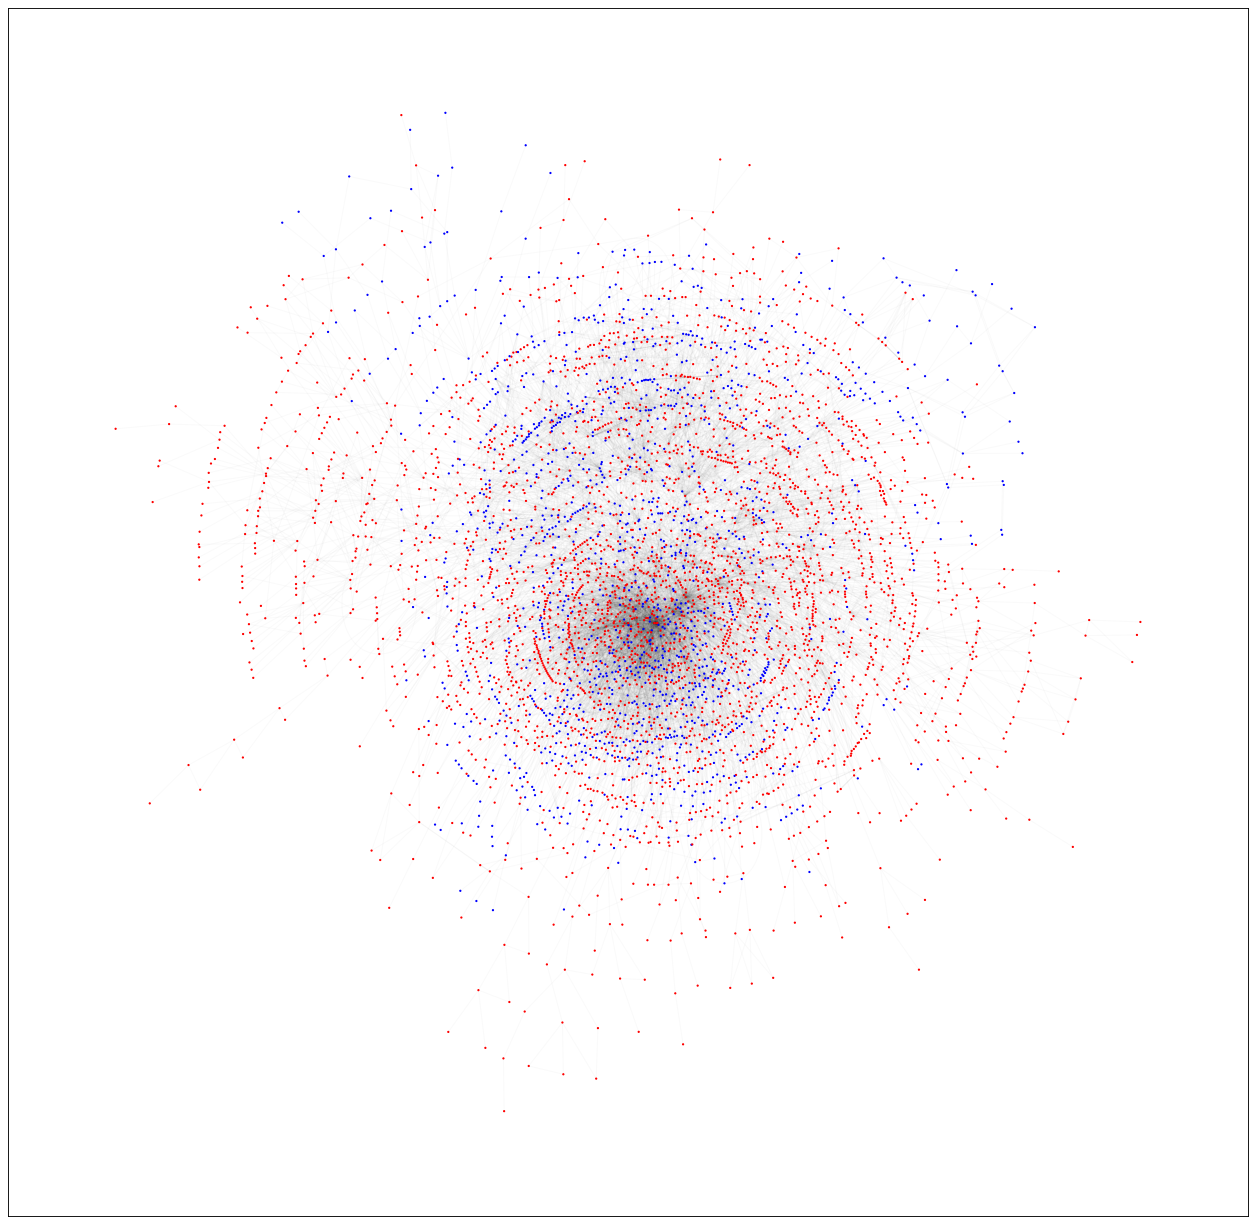

In [50]:
plt.figure(figsize=(20,20), dpi=80)
color_map = []
for node in G_undirected_main:
    if node in lsA:
        color_map.append('blue')
    else: 
        color_map.append('red') 
# nx.draw(G_undirected_main,node_size=1, node_color = color_map)
# pos=nx.spring_layout(G_undirected_main)
pos=nx.kamada_kawai_layout(G_undirected_main)
nx.draw_networkx_nodes(G_undirected_main, pos, node_size=1, node_color = color_map)
nx.draw_networkx_edges(G_undirected_main, pos, alpha=0.02)

In [45]:
import numpy as np


def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
#         pos_subgraph = nx.kamada_kawai_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [23]:
part_dict = {}

for node in lsA:
    part_dict[node] = 0
    
for node in lsB:
    part_dict[node] = 1
    


# Kamada kawai

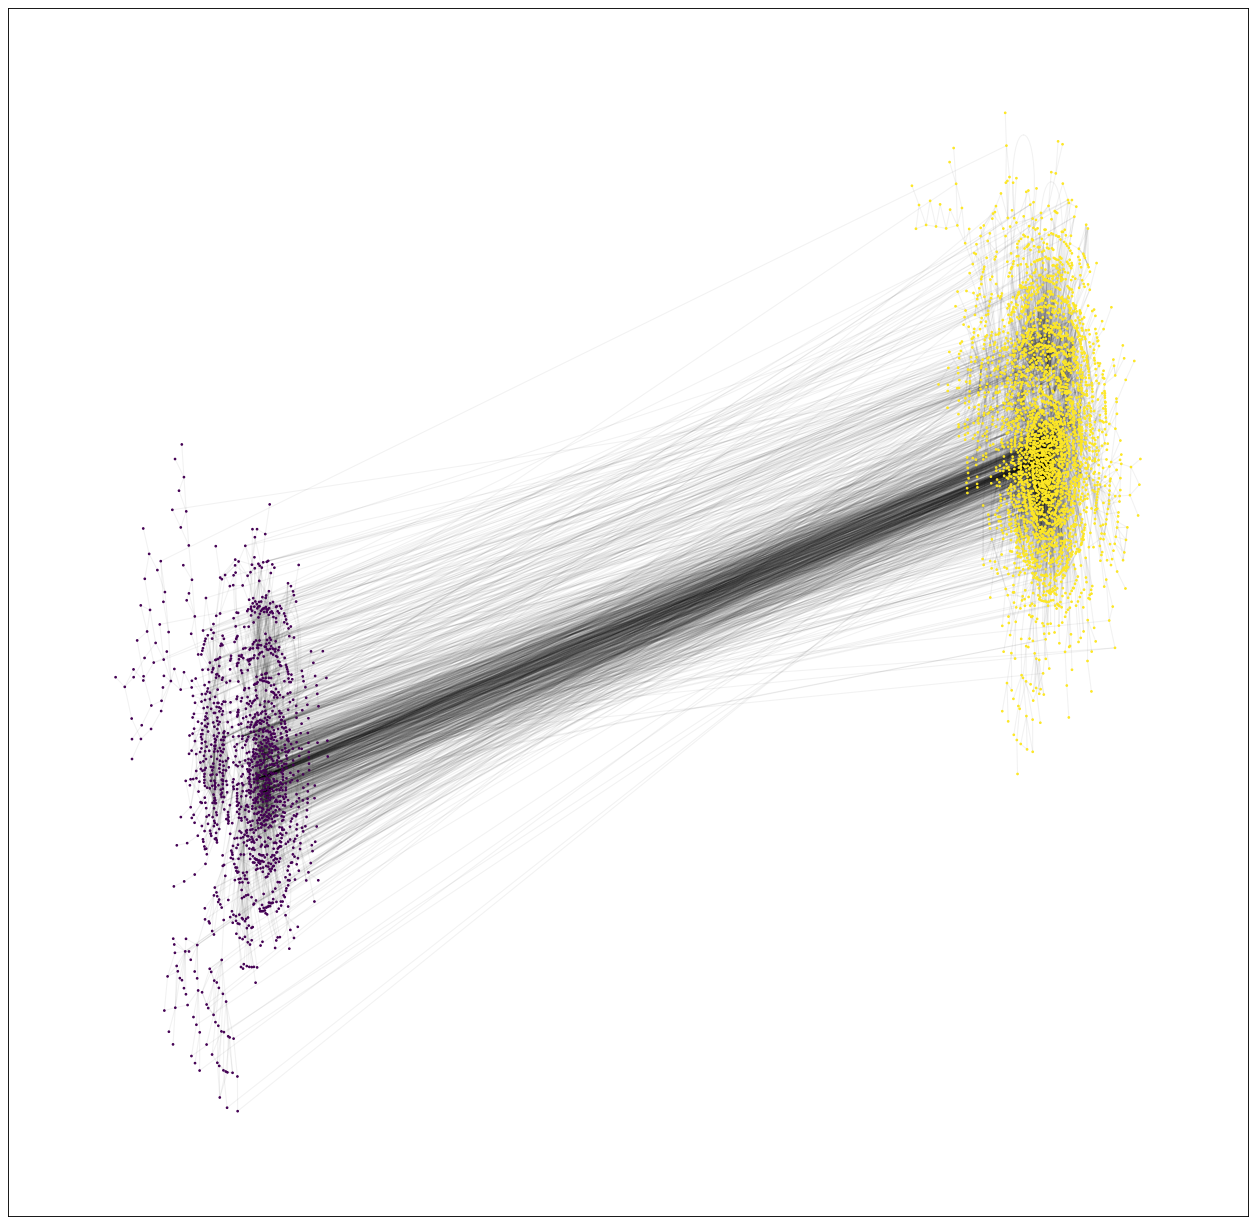

In [34]:
plt.figure(figsize=(20,20), dpi=80)
# nx.draw(G_undirected_main,node_size=1, node_color = color_map)
pos = community_layout(G_undirected_main, part_dict)
cmap = cm.get_cmap('viridis', max(part_dict.values()) + 1)
nx.draw_networkx_nodes(G_undirected_main, pos, part_dict.keys(), node_size=2,
                       cmap=cmap, node_color=list(part_dict.values()))
nx.draw_networkx_edges(G_undirected_main, pos, alpha=0.05)

# Spring Layout

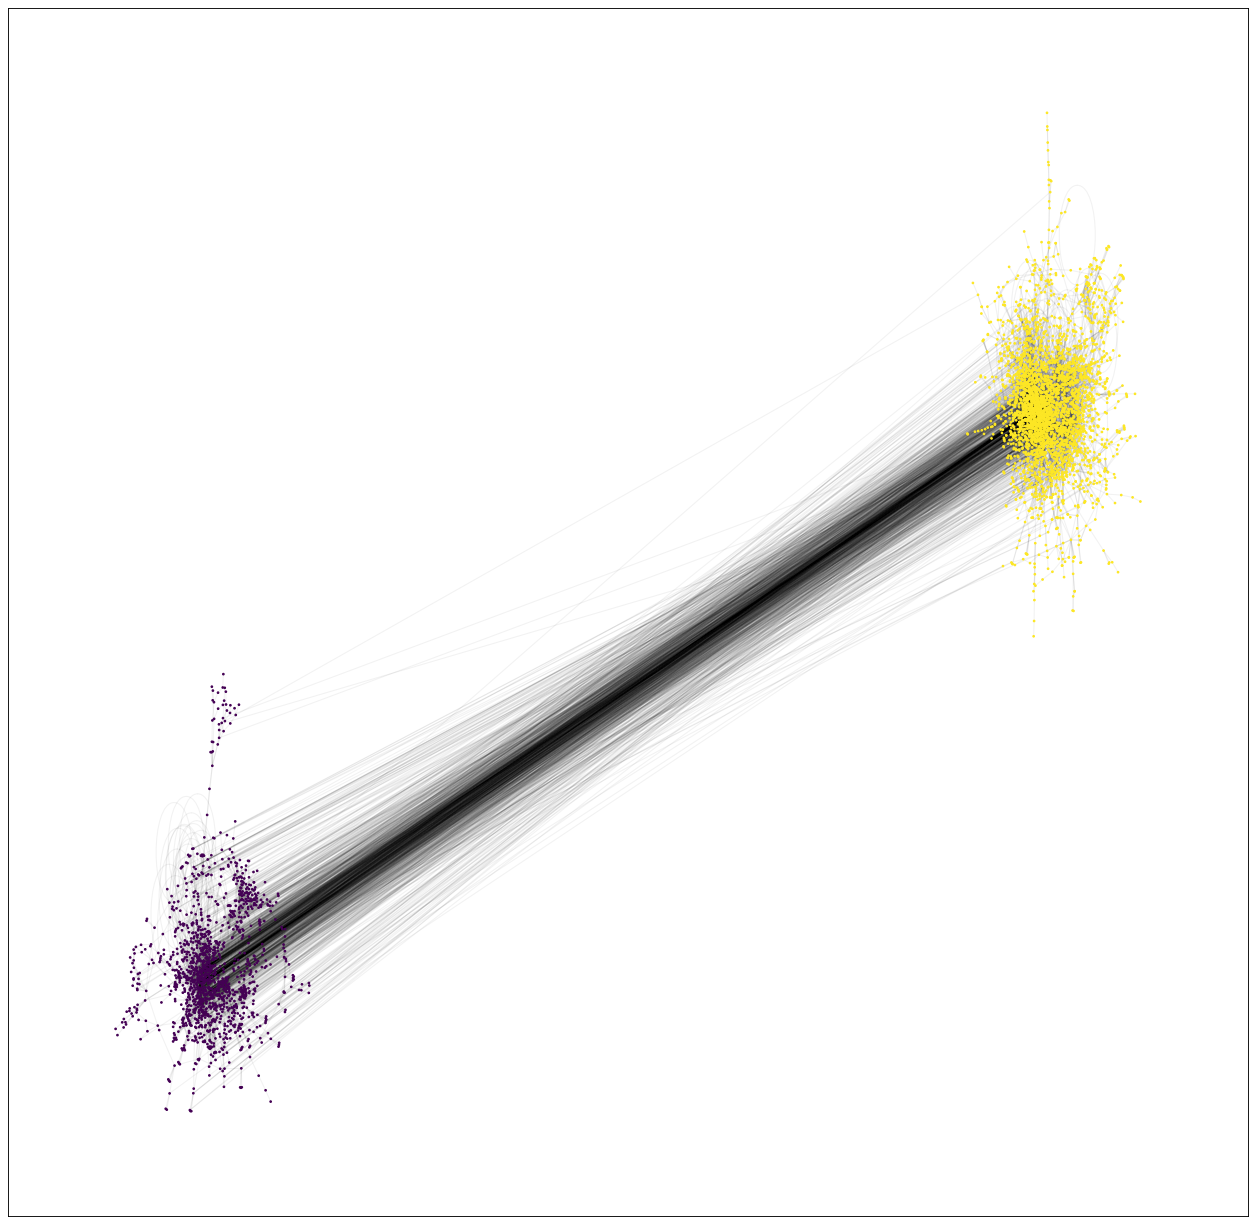

In [28]:
plt.figure(figsize=(20,20), dpi=80)
# nx.draw(G_undirected_main,node_size=1, node_color = color_map)
pos = community_layout(G_undirected_main, part_dict)
cmap = cm.get_cmap('viridis', max(part_dict.values()) + 1)
nx.draw_networkx_nodes(G_undirected_main, pos, part_dict.keys(), node_size=2,
                       cmap=cmap, node_color=list(part_dict.values()))
nx.draw_networkx_edges(G_undirected_main, pos, alpha=0.05)